# Preprocess data

In [1]:
# Get data from file
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update([',','\'','.','\"','...','`','#','$','%','&','*',';',':','/b','u','gt','lt','//','\'s','\'\'','-','reuter'])
classes = np.array([1,2,3,4])
training_filename = 'ag_news_csv/train.csv'
testing_filename = 'ag_news_csv/test.csv'
col_names = ['class','title','description']
training = pd.read_csv(training_filename, names=col_names)
testing = pd.read_csv(testing_filename, names=col_names)

tokenizer=nltk.tokenize.TreebankWordTokenizer()
stemmer = nltk.stem.PorterStemmer()
lemmer = nltk.stem.WordNetLemmatizer()

rgx_list = ['(\w+[A-Z]+.*\-+\s)','(\({1}\w+[\.*\s*\w*]*\){1})']

def token_stem_lem(text):
    # remove location of article before first - , and any source denoted by parenthesis
    new_text = text
    for rgx_match in rgx_list:
        new_text = re.sub(rgx_match, '', new_text)
    words_stemmed_lemmed = []
    for word in tokenizer.tokenize(new_text):
        new_word = stemmer.stem(lemmer.lemmatize(word.lower()))
        if new_word not in stop_words :
            words_stemmed_lemmed.append(new_word)
    return words_stemmed_lemmed

def to_onehot(y, class_rng):
    res = []
    for i in class_rng:
        if y is i:
            res.append(1)
        else:
            res.append(0)
    return res

testing['title_proc'] = testing['title'].apply(lambda title: token_stem_lem(title))
testing['descrip_proc'] = testing['description'].apply(lambda desc: token_stem_lem(desc))
testing['onehot'] = testing['class'].apply(lambda y: to_onehot(y, range(1, classes.shape[0] + 1)))
training['title_proc'] = training['title'].apply(lambda title: token_stem_lem(title))
training['descrip_proc'] = training['description'].apply(lambda desc: token_stem_lem(desc))
training['onehot'] = training['class'].apply(lambda y: to_onehot(y, range(1, classes.shape[0] + 1)))

[nltk_data] Downloading package wordnet to /home/mike/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mike/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 

In [2]:
training

,class,title,description,title_proc,descrip_proc,onehot
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...","[wall, st., bear, claw, back, black]","[short-sel, wall, street, dwindling\band, ultr...","[0, 0, 1, 0]"
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,"[carlyl, look, toward, commerci, aerospac]","[privat, invest, firm, carlyl, group, \which, ...","[0, 0, 1, 0]"
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,"[oil, economi, cloud, stock, outlook]","[soar, crude, price, plu, worries\about, econo...","[0, 0, 1, 0]"
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,"[iraq, halt, oil, export, main, southern, pipe...","[author, halt, oil, export\flow, main, pipelin...","[0, 0, 1, 0]"
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","[oil, price, soar, all-tim, record, pose, new,...","[tearaway, world, oil, price, toppl, record, s...","[0, 0, 1, 0]"
...,...,...,...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,"[pakistan, musharraf, say, wo, n't, quit, armi...","[pakistani, presid, pervez, musharraf, ha, sai...","[1, 0, 0, 0]"
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,"[renteria, sign, top-shelf, deal]","[red, sox, gener, manag, theo, epstein, acknow...","[0, 1, 0, 0]"
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,"[saban, go, dolphin, yet]","[miami, dolphin, put, courtship, lsu, coach, n...","[0, 1, 0, 0]"
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,"[today, nfl, game]","[pittsburgh, ny, giant, time, 1:30, p.m., line...","[0, 1, 0, 0]"


# Feature Selection

Updates a dictionary of all words used and their term frequency per class as a list.

In [ ]:
word_dict = {}
def update_word_dict(row, col):
    for word in row[col]:
        if not word in word_dict:
            word_dict[word] = [0,0,0,0]
        word_dict[word][row['class'] - 1] += 1

for index, row in training.iterrows():
    update_word_dict(row, 'descrip_proc')
    


The sort_top_words method will return the top n words as a dictionary where the value of the word is its place.

In [ ]:
# Takes a very long time.
import operator
top_words_amount = 2000

def sort_top_words(word_dict, top_words_amount, clas):
    top_words = {}
    for i in range(top_words_amount):
        word = max(word_dict, key=lambda word: word_dict[word][clas])
        top_words[word] = i
        word_dict[word][clas] = 0
    return top_words
        
classes_amount = 4
top_words = [sort_top_words(word_dict, top_words_amount, class_num) for class_num in range(classes_amount)]

# Construct Examples

The following block uses the top_words dictionary as a vocabulary for the tfidf victorizer. The result is the tfidf value of each word in the dictionary corrisponding to its use in each sample article.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(row):
    return row

tfidf = TfidfVectorizer(
    tokenizer=identity_tokenizer, 
    analyzer='word', 
    preprocessor=identity_tokenizer, 
    token_pattern=None,
    vocabulary=top_words[0]
)

tfidf.fit(training['descrip_proc'])
X_train = tfidf.transform(training['descrip_proc']).toarray()
Y_train = np.array(training['class'])
Y_train_oh = np.array(training['onehot'].tolist())
X_test = tfidf.transform(testing['descrip_proc']).toarray()
Y_test = np.array(testing['class'])
Y_test_oh = np.array(testing['onehot'].tolist())

# Classifiers

## Logistic Regression

The Logistic_regression function is my logistic regression algorithm which I attemt to adhere to the scikit-learn estimator scheme. By implementing the methods get_params, set_params, fit, predict and score, my logistic regression algorithm should be able to be used by GridsearchCV. It uses Mini-Batch Gradient Descent and Stochastic Gradient Descent.

In [2]:
# import math
import random
import math
from scipy import sparse
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from numpy import linalg as la


class Logistic_regression(BaseEstimator):

    def __init__(self, 
                 epochs = 10, 
                 batch_samples = 5000, 
                 learning_rate=0.01, 
                 gd_type='mini-batch', 
                 lambda_reg=0.01,
                 verbose=True):
        self.epochs = epochs
        self.batch_samples = batch_samples
        self.learning_rate = learning_rate
        self.gd_type = gd_type
        self.lambda_reg = lambda_reg
        self.verbose = verbose
        
    def get_params(self, deep=True):
        params = {
                'epochs': self.epochs,
                'batch_samples': self.batch_samples,
                'learning_rate': self.learning_rate,
                'gd_type': self.gd_type,
                'lambda_reg': self.lambda_reg
            }
        return params

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
        
    def to_onehot(self, y, classes):
        result = np.zeros((y.shape[0], classes.shape[0]))
        for i, row in enumerate(result):
            row[y[i] - 1] = 1
        return result
    
    def from_onehot(self, y):
        return np.array([np.argmax(i) for i in y.T])
        
    def get_phi(self, x):
        return self.w.dot(x)

    def softmax(self, x):
        phi = self.get_phi(x)
        phi_sum = np.zeros(phi.shape[1])
        for i in range(phi.shape[0]):
            phi_sum += np.exp(phi[i,:])
        return phi / phi_sum[None, :]

    def gradient(self, p, y, x):
        cross_entropy = p - y
        return cross_entropy.dot(x.T) + self.lambda_reg * self.w
    
    # accepts ground truth, y in one hot encoding and predicted vector p and returns float entropy
    def cross_entropy(self, y, p):
        p = np.array(list(map(lambda i: math.log(i,10), p)))
        return np.array(y).dot(p.T) * -1
    
    def find_loss(self, y, p):
        n = y.shape[1]
        prob_tmp  = np.where(p > 1.0e-10, p, 1.0e-10)
        pp = np.where(p > 1.0e-10, np.log10(prob_tmp), 1.0e-10)
        return (-1 / n) * np.sum(y * pp) #+ self.lambda_reg * la.norm(self.w)
    
    def mini_batch(self, x, y): #
        for epoch in range(self.epochs):
            gradients = np.zeros(self.w.shape)
            xrand = np.random.randint(x.shape[1], size=self.batch_samples)
            x = np.array([x[:,i] for i in xrand]).T
            y = np.array([y[:,i] for i in xrand]).T
            p = self.softmax(x)
            dw = self.gradient(p, y, x)
            self.w = self.w - self.learning_rate * dw
            score = accuracy_score(self.from_onehot(y), self.from_onehot(p))
            loss = self.find_loss(y, p)
            self.score_log.append(score)
            self.loss_log.append(loss)
            if self.verbose: print('Epoch %d complete. Score: %1.5f, and Loss: %1.5f' % (epoch, score, loss))
        return self

    def stochastic(self, x, y):
        for epoch in range(self.epochs):
            for _ in range(self.batch_samples):
                i = np.random.randint(x.shape[0])
                p = self.softmax(x[i])
                grad = self.gradient(p, y[i], x[i])
                self.losses.append(self.cross_entropy(y[i], p))
                self.w = self.w - self.learning_rate * np.add(grad, np.multiply(self.lambda_reg, self.w))
            print('Epoch %d complete. Traning loss: %1.4f' % (epoch, self.find_loss(self.losses[-self.batch_samples:])))
        return self
        
    def fit(self, x, y, classes=None):
        x = x.T
        if classes is None:
            y = y.T
        else:
            y = self.to_onehot(y, classes).T
        features = x.shape[0]
        classes = y.shape[0]
        self.w = np.zeros((classes, features))
        self.loss_log = []
        self.score_log = []
        if self.gd_type == 'mini-batch':
            self.mini_batch(x, y)
        if self.gd_type == 'stochastic':
            self.stochastic(x, y)
        return self
    
    def predict(self, x):
        return self.softmax(x.T)
    
    def score(self, x, y):
        p = self.predict(x)
        y = y.T
        return accuracy_score(self.from_onehot(y), self.from_onehot(p))
    
    def get_stats(self):
        return (self.score_log, self.loss_log)
    

In [10]:
def softmax(phi):
    phi_sum = np.zeros(phi.shape[0])
    for i in range(phi.shape[0]):
        phi_sum += np.exp(phi[i])
    return phi / phi_sum

softmax(np.array([-1,0,1,2,3]))

array([-0.03168492,  0.        ,  0.03168492,  0.06336984,  0.09505476])

In [13]:
(5 * 5 * 3 + 1) * 20

1520

In [17]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import GridSearchCV

clf = svm.SVC(random_state=0)

ftwo_scorer = make_scorer(fbeta_score, beta=2)

params_to_be_compared = [{
        'epochs' : [10, 30, 50],
        'batch_samples' : [i * 1000 for i in range(1,9,2)],
        'learning_rate' : [1/10**i for i in range(1,6)],
        'gd_type' : ['mini-batch'],
        'lambda_reg' : [10**i/100 for i in range(1,5)],
        'verbose' : [False]
    }]

test_p = [{
        'verbose' : [False],
        'epochs': [10,20]
    }]

lrgs = GridSearchCV(Logistic_regression(), param_grid=params_to_be_compared, cv=3)
lrgs_results = lrgs.fit(X=X_train, y=Y_train_oh)
print('The best accuracy my Logistic Regression function calculated was %0.5f and the parameters were: ' %(lrgs_results.best_score_))
print(lrgs_results.best_params_)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in t

Epoch 0 complete. Score: 0.2511
Epoch 1 complete. Score: 0.8060
Epoch 2 complete. Score: 0.8237
Epoch 3 complete. Score: 0.8294
Epoch 4 complete. Score: 0.8300
Epoch 5 complete. Score: 0.8350
Epoch 6 complete. Score: 0.8366
Epoch 7 complete. Score: 0.8443
Epoch 8 complete. Score: 0.8584
Epoch 9 complete. Score: 0.8699
The best accuracy my Logistic Regression function calculated was 0.75775 and the parameters were: 
<built-in method values of dict object at 0x7f0534ff9e58>


In [93]:
print(lrgs_results.best_params_)
bp = lrgs_results.best_params_
bp['verbose'] = True
lr = Logistic_regression()
lr.set_params(**bp)
lr.fit(X_train, Y_train_oh)
lr_scores, lr_losses = lr.get_stats()

{'batch_samples': 7000, 'epochs': 10, 'gd_type': 'mini-batch', 'lambda_reg': 10.0, 'learning_rate': 0.001, 'verbose': True, 'verbos': True}
Epoch 0 complete. Score: 0.24514, and Loss: -0.00000
Epoch 1 complete. Score: 0.77614, and Loss: 2.02515
Epoch 2 complete. Score: 0.79029, and Loss: 1.73547
Epoch 3 complete. Score: 0.79543, and Loss: 1.57167
Epoch 4 complete. Score: 0.80671, and Loss: 1.45631
Epoch 5 complete. Score: 0.81386, and Loss: 1.37164
Epoch 6 complete. Score: 0.81643, and Loss: 1.30777
Epoch 7 complete. Score: 0.82214, and Loss: 1.25276
Epoch 8 complete. Score: 0.82714, and Loss: 1.20661
Epoch 9 complete. Score: 0.83871, and Loss: 1.16653


## Multilayer Perceptron Network

Along the lines of the logistic regression class, my Multilayer_Perceptron class also adheres to the scikit-learn estimator scheme.

In [41]:
class Multilayer_Perceptron():
    def __init__(self, 
                 verbose = True, 
                 epochs = 20, 
                 neurons = 50, 
                 batch_samples = 5000, 
                 learning_rate=0.01):
        self.verbose = verbose
        self.epochs = epochs
        self.neurons = neurons
        self.batch_samples = batch_samples
        self.learning_rate = learning_rate
        
    def get_params(self, deep=True):
        params = {
                'verbose' : self.verbose,
                'epochs' : self.epochs,
                'neurons' : self.neurons,
                'batch_samples' : self.batch_samples,
                'learning_rate' : self.learning_rate
            }
        return params
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def to_onehot(self, y, classes):
        result = np.zeros((y.shape[0], classes.shape[0]))
        for i, row in enumerate(result):
            row[y[i] - 1] = 1
        return result
    
    def from_onehot(self, y):
        return np.array([np.argmax(i) for i in y.T])
    
    def get_z(self, w, x, b):
        return w.T.dot(x) + b
    
    def sigmoid(self, z):
        return 1/(1 + np.exp(z))
    
    def sigmoid_gradient(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def softmax(self, z):
        z_sum = 0
        for i in z:
            z_sum += math.exp(i)
        if z_sum == 0:
            print(z)
        return np.array([math.exp(ze)/z_sum for ze in z]).reshape(z.shape)
    
    def softmax(self, z):
        z_sum = np.zeros(z.shape[1])
        for i in range(z.shape[0]):
            z_sum += np.exp(z[i,:])
        return z / z_sum[None, :]
    
        # accepts ground truth, y in one hot encoding and predicted vector p and returns float entropy
    def cross_entropy(self, y, p):
        p = np.array(list(map(lambda i: math.log(i,10), p)))
        return np.array(y).dot(p.T) * -1
    
    def find_loss(self, y, h):
        n = y.shape[0]
        print(n)
        h = np.log10(h.T)
        return (-1 / n) * np.sum(h * y)
    
    def gradient_check(self, y, p, epsilon = 1/10**4):
        return self
    
    def fit(self, x, y):
        x = x.T
        y = y.T
        features = x.shape[0]
        classes = y.shape[0]
        samples = self.batch_samples
        self.w1 = np.zeros((features, self.neurons))
        self.b1 = np.zeros((self.neurons, samples))
        self.w2 = np.zeros((self.neurons, classes))
        self.b2 = np.zeros((classes, samples))
        
        for epoch in range(self.epochs):
            dw1 = np.zeros((self.w1.shape))
            db1 = np.zeros((self.b1.shape))
            dw2 = np.zeros((self.w2.shape))
            db2 = np.zeros((self.b2.shape))
            
            xrand = np.random.randint(x.shape[1], size=self.batch_samples)
            x = np.array([x[:,i] for i in xrand]).T
            y = np.array([y[:,i] for i in xrand]).T

                
            #forward Prop
            z1 = self.get_z(self.w1, x, self.b1) #neuronsxsamples
            h1 = self.sigmoid(z1)       #neuronsxsamples
            z2 = self.get_z(self.w2, h1, self.b2) #classesxsamples
            h2 = self.softmax(z2)       #classesxsamples

            #backprop                
            dJ_dz2 = h2 - y            #classsesxsamples
            dw2 += dJ_dz2.dot(h1.T).T    #classesxneurons
            db2 += dJ_dz2                #classesxsamples
            dz2_dh1 = self.w2                #neuronsxclasses
            dJ_dh1 = dJ_dz2.T.dot(dz2_dh1.T) #samplesxneurons
            dh1_dz1 = self.sigmoid_gradient(h1) #neuronsxsamples
            dz1_dw1 = x                #featuresxsamples

            # Update epoch summations
            db1 += dJ_dh1.T * dh1_dz1
            dw1 += dz1_dw1.dot(db1.T)
            
            # Update weights
            self.w1 -= dw1 * self.learning_rate
            self.b1 -= db1 * self.learning_rate
            self.w2 -= dw2 * self.learning_rate
            self.b2 -= db2 * self.learning_rate
            
            # Calculate Score
            #print('Epoch %d complete. Traning loss: %1.4f' % (epoch, self.find_loss(losses[-self.batch_samples:])))
            score = accuracy_score(self.from_onehot(y), self.from_onehot(h1))
            if self.verbose: print('Epoch %d complete. Score: %1.4f' % (epoch, score))            
            
    def predict(self, x):
        xi = np.array(x[i]).reshape(x[i].shape[0], 1)

        #forward Prop
        z1 = self.get_z(w1, xi, b1) #neuronsx1
        h1 = self.sigmoid(z1)       #neuronsx1
        z2 = self.get_z(w2, h1, b2) #classesx1
        h2 = self.softmax(z2)       #classesx1
        return h2
    
    def score(self, x, y):
        p = self.predict(x)
        y = y.T
        return accuracy_score(self.from_onehot(y), self.from_onehot(p))

In [42]:
mlp = Multilayer_Perceptron()
mlp.fit(X_train, Y_train_oh) 

Epoch 0 complete. Score: 0.2490
Epoch 1 complete. Score: 0.2620
Epoch 2 complete. Score: 0.2588
Epoch 3 complete. Score: 0.2492
Epoch 4 complete. Score: 0.2374
Epoch 5 complete. Score: 0.2568
Epoch 6 complete. Score: 0.2694
Epoch 7 complete. Score: 0.2580
Epoch 8 complete. Score: 0.2472
Epoch 9 complete. Score: 0.2366
Epoch 10 complete. Score: 0.2506
Epoch 11 complete. Score: 0.2576
Epoch 12 complete. Score: 0.2400
Epoch 13 complete. Score: 0.2188
Epoch 14 complete. Score: 0.2214
Epoch 15 complete. Score: 0.2322
Epoch 16 complete. Score: 0.2136
Epoch 17 complete. Score: 0.2380
Epoch 18 complete. Score: 0.2318
Epoch 19 complete. Score: 0.2200


In [ ]:
params_to_be_compared = [{
        'epochs' : [10, 30, 50],
        'neurons' : [30, 50, 70],
        'batch_samples' : [i * 1000 for i in range(1,9,2)],
        'learning_rate' : [1/10**i for i in range(1,6)],
        'verbose' : [False]
    }]

lrgs = GridSearchCV(Multilayer_Perceptron(), param_grid=params_to_be_compared, cv=3)
lrgs_results = lrgs.fit(X=X_train, y=Y_train_oh)
print('The best accuracy my Logistic Regression function calculated was %0.5f and the parameters were: ' %(lrgs_results.best_score_))
print(lrgs_results.best_params_)

# Results

The recall for training data is as follows. It is sorted by class and contains the top 2000 words per class.

In [100]:
top_words

[{'said': 0,
  '39': 1,
  'hi': 2,
  'ha': 3,
  'wa': 4,
  'presid': 5,
  'kill': 6,
  'minist': 7,
  'iraq': 8,
  'two': 9,
  'offici': 10,
  'peopl': 11,
  'govern': 12,
  'quot': 13,
  'leader': 14,
  'state': 15,
  'prime': 16,
  'elect': 17,
  'nation': 18,
  'new': 19,
  'monday': 20,
  'say': 21,
  'countri': 22,
  'wednesday': 23,
  'iraqi': 24,
  'attack': 25,
  'thursday': 26,
  'palestinian': 27,
  'friday': 28,
  'tuesday': 29,
  'sunday': 30,
  'year': 31,
  'secur': 32,
  'yesterday': 33,
  'unit': 34,
  'forc': 35,
  'report': 36,
  'polic': 37,
  'militari': 38,
  'bomb': 39,
  'bush': 40,
  'three': 41,
  'day': 42,
  'week': 43,
  'saturday': 44,
  'one': 45,
  'least': 46,
  'u.s.': 47,
  'citi': 48,
  'first': 49,
  'isra': 50,
  'group': 51,
  'milit': 52,
  'nuclear': 53,
  'would': 54,
  'troop': 55,
  'thi': 56,
  'plan': 57,
  '``': 58,
  'baghdad': 59,
  'talk': 60,
  'war': 61,
  'last': 62,
  'today': 63,
  'british': 64,
  'foreign': 65,
  'end': 66,
  'for

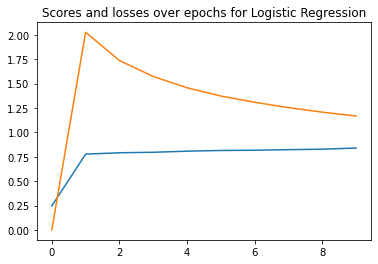

In [97]:
import matplotlib.pyplot as plt

x_plot = np.array(range(bp['epochs']))
plt.title('Scores and losses over epochs for Logistic Regression')
plt.plot(x_plot, lr_scores, x_plot, lr_losses)
plt.show()